In [1]:
# Initializing


import pandas as pd 

import numpy as np 


%matplotlib inline

import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()

sns.set_style("darkgrid")

# ignore sklearn & seaborn warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 


from scipy import stats
from scipy.stats import norm, skew  #ex. sns(fit = norm)


# Format scientific notation from pandas aggregation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [164]:
df_dummies = pd.read_csv('data/all_data.csv')
df_no_dummies = pd.read_csv('data/all_data_no_dummies.csv') 

In [3]:
targets = pd.read_csv('data/y_train.csv') 

In [46]:
from sklearn.model_selection import GridSearchCV, train_test_split 

from sklearn import linear_model as lm 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 

from sklearn.metrics import mean_squared_error  

#rmse error: 
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))  

### Split all_data into train and test: 

In [165]:
ntrain = targets.shape[0] 
x_d = df_dummies[:ntrain] 
x_nd = df_no_dummies[:ntrain] 
targets_log = targets.apply(np.log)


In [6]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
scaler.fit(x_d)
x_d_std = scaler.transform(x_d)



### Split x_d_std and targets into train and test using train_test_split: 

In [7]:
x_d_train, x_d_test, y_d_train, y_d_test = train_test_split(x_d_std, targets_log, test_size = 0.2, random_state = 42) 


## MODELLING

### 1. Multiple Linear Regression: 

In [59]:
lm_model =lm.LinearRegression()
lm_model.fit(x_d_train, y_d_train)

#RMS error 
print("RMSE train: {}".format(rmse(y_d_train, lm_model.predict(x_d_train)))) 
print("RMSE test : {}".format(rmse(y_d_test,  lm_model.predict(x_d_test)))) 
print('R^2 score: {}'.format(lm_model.score(x_d_train, y_d_train)))




RMSE train: 0.17318243900299812
RMSE test : 15562705841228.213
R^2 score: 0.8014776983376941


### 2. Ridge/Lasso/Elastic Net : Penalised LR 

In [70]:
#1. ridge: 

grid_param = [{'alpha': np.linspace(1e-3,20,20)}]

gs = GridSearchCV(estimator=lm.Ridge(random_state=42), param_grid=grid_param, cv=5)

gs.fit(x_d_std, targets_log)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, model.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test,  model.predict(x_d_test))))
print('R^2 score: {}'.format(model.score(x_d_train, y_d_train))) 

Best params: {'alpha': 20.0}
Best score : 0.7480641187701964
RMSE train: 0.17316473428517343
RMSE test : 0.18610748181507164
R^2 score: 0.8015182867679322


In [73]:
#2. Lasso: 

grid_param = [{'alpha': np.linspace(1e-3,20,20)}] 

gs = GridSearchCV(estimator=lm.Lasso(random_state= 42, normalize=False), param_grid=grid_param, cv=5)

gs.fit(x_d_std, targets_log)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, model.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test,  model.predict(x_d_test)))) 


Best params: {'alpha': 0.001}
Best score : 0.7493747517752001
RMSE train: 0.17342910634294778
RMSE test : 0.18603750059370833


In [75]:
model.fit(x_d, targets_log)
print('The intercept is %.4f' %(model.intercept_))
lassoCoef = pd.Series(model.coef_, index=x_d.columns)
print('The slopes are \n%s' %(lassoCoef))  

The intercept is 5.6668
The slopes are 
ExterQual              -0.000
Fireplaces              0.041
GarageArea              0.000
GrLivArea               0.000
HeatingQC               0.014
KitchenQual             0.036
OverallQual             0.063
TotRmsAbvGrd            0.000
Num_Bathrooms           0.034
HouseSF                 0.000
YearRemodAgg            0.003
Exterior1st_AsbShng    -0.016
Exterior1st_AsphShn    -0.000
Exterior1st_BrkComm    -0.000
Exterior1st_BrkFace     0.027
Exterior1st_CBlock     -0.000
Exterior1st_CemntBd    -0.000
Exterior1st_HdBoard     0.008
Exterior1st_ImStucc     0.000
Exterior1st_MetalSd     0.003
Exterior1st_Plywood    -0.005
Exterior1st_Stone       0.000
Exterior1st_Stucco      0.007
Exterior1st_VinylSd    -0.011
Exterior1st_Wd Sdng     0.000
Exterior1st_WdShing    -0.000
Foundation_BrkTil      -0.000
Foundation_CBlock       0.000
Foundation_PConc        0.000
Foundation_Slab        -0.000
                        ...  
HouseStyle_SLvl         0.000


In [76]:
#3: Elastic Net 

grid_param = [{'alpha': np.linspace(1e-3,20,20), 'l1_ratio': np.linspace(0.015, 1, 20)}]

# Confirmed that setting scoring='neg_mean_squared_error' is the same result as using the default "R2" score.
gs = GridSearchCV(estimator=lm.ElasticNet(random_state=42), param_grid=grid_param, cv=5)

gs.fit(x_d_std, targets_log) 

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_)) 
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, model.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test, model.predict(x_d_test))))  

Best params: {'alpha': 0.001, 'l1_ratio': 1.0}
Best score : 0.7493747517752001
RMSE train: 0.17342910634294778
RMSE test : 0.18603750059370833


In [77]:
#proportion of coeffs > 1e-6 out of all coeffs 

sum(model.coef_ > 1e-6) / model.coef_.shape[0] 

0.4782608695652174

Preparation for tree-based models: encode nominal categorical variables in x_nd df: 

In [166]:
x_nd.columns

Index(['Unnamed: 0', 'ExterQual', 'Exterior1st', 'Fireplaces', 'Foundation', 'GarageArea', 'GrLivArea', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotShape', 'Neighborhood', 'OverallQual', 'TotRmsAbvGrd', 'Num_Bathrooms', 'HouseSF', 'YearRemodAgg'], dtype='object')

In [167]:
#drop first column, and determine which columns are nominal categorical 

x_nd = x_nd.drop('Unnamed: 0', axis = 1)
x_nd.select_dtypes(['object']) 

,Exterior1st,Foundation,HouseStyle,LotShape,Neighborhood
0,VinylSd,PConc,2Story,Reg,CollgCr
1,MetalSd,CBlock,1Story,Reg,Veenker
2,VinylSd,PConc,2Story,IR1,CollgCr
3,Wd Sdng,BrkTil,2Story,IR1,Crawfor
4,VinylSd,PConc,2Story,IR1,NoRidge
5,VinylSd,Wood,1.5Fin,IR1,Mitchel
6,VinylSd,PConc,1Story,Reg,Somerst
7,HdBoard,CBlock,2Story,IR1,NWAmes
8,BrkFace,BrkTil,1.5Fin,Reg,OldTown
9,MetalSd,BrkTil,1.5Unf,Reg,BrkSide


In [168]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
HouseSF', 0.2725794204816994),
 ('OverallQual', 0.18367601255210747),
 ('KitchenQual', 0.12356260364685952),
 ('YearRemodAgg', 0.09478348853681917),
 ('HouseStyle', 0.07907912271330644),
 ('Neighborhood', 0.05854045717122344),
 ('Num_Bathrooms', 0.05841803302668867)

In [169]:
#use LabelEncode to encode categorical vars 

lencoder = LabelEncoder()

exterior1st_labels  =lencoder.fit_transform(x_nd.Exterior1st).reshape((-1,1))
#foundation_labels = lencoder.fit_transform(x_nd.Foundation).reshape((-1,1))  
housestyle_labels    = lencoder.fit_transform(x_nd.HouseStyle).reshape((-1,1))
#lotshape_labels   = lencoder.fit_transform(x_nd.LotShape).reshape((-1,1))
neighborhood_labels= lencoder.fit_transform(x_nd.Neighborhood).reshape((-1,1))  

In [227]:
#create list numerical + encoded nominal categorical features 

num_cols = ['KitchenQual','OverallQual', 'Num_Bathrooms', 'HouseSF', 'YearRemodAgg']
x_nd_le = [neighborhood_labels]
for col in num_cols: 
    x_nd_le.append(x_nd[col].reshape((-1, 1))) 
    

In [228]:
#concatenate features (including encoded nominal categorical variables)-> new dataframe 

x_nd_le = np.concatenate(x_nd_le, axis = 1)
x_nd_le = pd.DataFrame(x_nd_le)  
x_nd_le.columns = ['neighborhood', 'kitchenqual', 'overallqual', 'num_bathrooms', 'housesf', 'year_remod_agg'] 

In [229]:
x_nd_le.head()

,neighborhood,kitchenqual,overallqual,num_bathrooms,housesf,year_remod_agg
0,5.000,3.000,7.000,4.000,3114.000,2003.000
1,24.000,2.000,6.000,3.000,2984.000,1976.000
2,5.000,3.000,7.000,4.000,3314.000,2001.500
3,6.000,3.000,7.000,2.000,3115.000,1942.500
4,15.000,3.000,8.000,4.000,4179.000,2000.000


In [230]:
#train_test split of non-dummified dataframe 

x_nd_train, x_nd_test, y_nd_train, y_nd_test = train_test_split(x_nd_le, targets_log, test_size = 0.2, random_state = 42)  


### 3. Random Forest 

In [301]:

#test random forest regressor with default parameters: 

randomForest = RandomForestRegressor()

# fit RF model on training set
randomForest.set_params(random_state=42)

randomForest.fit(x_nd_train, y_nd_train)  

print("The training error is: %.5f" % (1- randomForest.score(x_nd_train, y_nd_train))) 
print("The test     error is: %.5f" % (1 - randomForest.score(x_nd_test, y_nd_test)))   

The training error is: 0.04859
The test     error is: 0.28646


In [295]:
grid_para_forest = {
    'n_estimators': range(80, 200, 10),
    'max_depth': range(3,12),
    'max_features': ['sqrt', 'auto']
}  

In [296]:
gs = GridSearchCV(estimator = RandomForestRegressor(\
                                    min_samples_split=5,\
                                    #max_depth = 10,\
                                    min_samples_leaf=1,\
                                    random_state=42,\
                                    n_jobs=-1),\
                  param_grid = grid_para_forest, n_jobs=-1, cv=5)   

In [297]:
gs.fit(x_nd_train, y_nd_train)  

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=5,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(3, 12),
          

In [298]:
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))   

Best params: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 90}
Best score : 0.7694308012689799


In [299]:
forest_final = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, forest_final.predict(x_nd_train)))) #0.1044
print("RMSE test : {}".format(rmse(y_d_test,  forest_final.predict(x_nd_test)))) #0.1962  

RMSE train: 0.13707762030026752
RMSE test : 0.19620686829323813


In [300]:

forest_feature_importance = forest_final.feature_importances_

forest_sorted_features = sorted(list(zip(x_nd_le.columns, forest_feature_importance)), key = lambda kv: kv[1], reverse = True) 

forest_sorted_features 

[('housesf', 0.4007116462865751),
 ('overallqual', 0.2153847488979508),
 ('year_remod_agg', 0.14127826204855218),
 ('kitchenqual', 0.11586024082597046),
 ('num_bathrooms', 0.08905445677203017),
 ('neighborhood', 0.03771064516892126)]

Text(0.5,1,'Feature Importance: Random Forest')

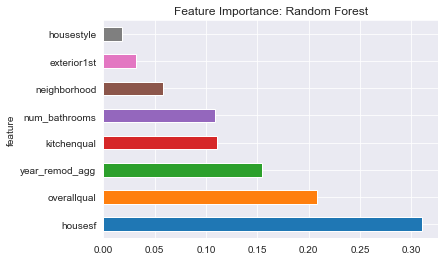

In [182]:
#graph feature importances of top 25 features 

a, b = zip(*forest_sorted_features)
importance_score = pd.DataFrame({'feature':a, 'score':b})
importance_score.plot.barh(x='feature', y='score', legend=None)
plt.title('Feature Importance: Random Forest')

### 4. GBM

In [200]:
gbm = GradientBoostingRegressor()  

In [231]:
gbm_1 = gbm.fit(x_nd_train, y_nd_train) 

print("The training error is: %.5f" % (1- gbm.score(x_nd_train, y_nd_train))) 
print("The test     error is: %.5f" % (1 - gbm.score(x_nd_test, y_nd_test)))   

The training error is: 0.14129
The test     error is: 0.26298


In [221]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbm.set_params(learning_rate = 1, n_estimators=n_estimators, max_depth=3)
gbm.fit(x_nd_train, y_nd_train)
gen = gbm.staged_predict(x_nd_train)
r2_rate1 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate1.append(r2_score(predicted_targets, y_nd_train))    

KeyboardInterrupt: 

In [186]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbm.set_params(learning_rate = 0.1, n_estimators=n_estimators, max_depth=3)
gbm.fit(x_nd_train, y_nd_train)
gen = gbm.staged_predict(x_nd_train)
r2_rate01 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate01.append(r2_score(predicted_targets, y_nd_train))    

In [211]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbm.set_params(learning_rate = 0.01, n_estimators=n_estimators, max_depth=3)
gbm.fit(x_nd_train, y_nd_train)
gen = gbm.staged_predict(x_nd_train)
r2_rate001 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate001.append(r2_score(predicted_targets, y_nd_train))    

KeyboardInterrupt: 

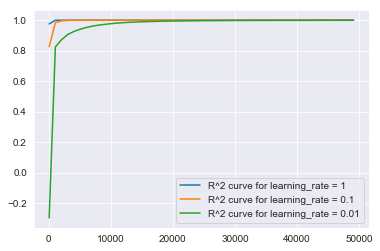

In [188]:
plt.plot(steps, r2_rate1,  label=r'R^2 curve for learning_rate = 1')
plt.plot(steps, r2_rate01, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_rate001, label=r'R^2 curve for learning_rate = 0.01')
plt.legend(loc=4) 

In [289]:
n_estimators = 3000
gbm.set_params(learning_rate=0.005, max_depth=5, max_features = 'sqrt', subsample = 0.9,  n_estimators=n_estimators, min_samples_split=7,
min_samples_leaf=10)

train_r2 = []
test_r2  = []
steps = range(100, 3000, 100)

gbm.fit(x_nd_train,y_nd_train)
gen_train = gbm.staged_predict(x_nd_train) #generators 
gen_test  = gbm.staged_predict(x_nd_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2.append(r2_score(predicted_train, y_nd_train))
           test_r2.append(r2_score(predicted_test, y_nd_test))        

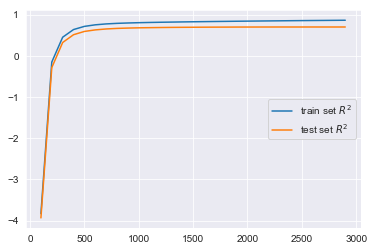

In [290]:
plt.plot(steps, train_r2, label='train set $R^2$')
plt.plot(steps, test_r2, label='test set $R^2$')
plt.legend(loc=7) 

In [302]:
max(train_r2)

0.8635334859829155

In [292]:
print("RMSE train: {}".format(rmse(y_nd_train, gbm.predict(x_nd_train))))
print("RMSE test : {}".format(rmse(y_nd_test,  gbm.predict(x_nd_test)))) 

RMSE train: 0.12971378419327143
RMSE test : 0.193305512794613


In [293]:
gbm_feature_importance = gbm.feature_importances_

gbm_sorted_features = sorted(list(zip(x_nd_le.columns, gbm_feature_importance)), key = lambda kv: kv[1], reverse = True) 

gbm_sorted_features 

[('housesf', 0.3997754496291378),
 ('overallqual', 0.24452923889272618),
 ('year_remod_agg', 0.14314877171759016),
 ('kitchenqual', 0.08674165118042029),
 ('num_bathrooms', 0.08266537505836453),
 ('neighborhood', 0.04313951352176089)]

In [237]:
grid_para_gbm = {
    'max_depth': range(3,12),
    'max_features': ['sqrt', 'auto'], 
    'min_samples_split':range(3,21,3), 
    'min_samples_leaf':np.arange(1,10,1),
    'subsample':[0.6,0.7,0.75,0.8,0.85,0.9], 
    'learning_rate': [0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1]   
}  

In [238]:
gs = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 500), param_grid = grid_para_gbm, n_jobs = -1, cv = 5)   

In [239]:
gs.fit(x_nd_train, y_nd_train) 

KeyboardInterrupt: 

In [ ]:
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_nd_train, model.predict(x_nd_train))))
print("RMSE test : {}".format(rmse(y_nd_test,  model.predict(x_nd_test))))